In [142]:
import pandas as pd
from pandas import read_excel
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from string import ascii_letters
import seaborn as sns
from datetime import datetime

import statsmodels.api as sm
from statsmodels.tsa.api import VAR

In [143]:
data = read_excel("monthly_data.xlsx")
dfa = pd.read_excel (r'monthly_data.xlsx')
print(type(data))
print(type(dfa))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [144]:
print(data.dtypes)

year              object
max_temp         float64
min_temp         float64
rainfall(mm)     float64
humidity         float64
dengue             int64
Leptospirosis      int64
dtype: object


In [145]:
data['year']=pd.to_datetime(data['year'], format = '%Y-%m')
data.set_index('year', inplace=True)
#check datatype of index
data.index

DatetimeIndex(['2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
      

In [146]:
#convert to time series:
ts1 = data['dengue']
ts1.head()

year
2014-01-01     1
2014-02-01     0
2014-03-01     0
2014-04-01     5
2014-05-01    28
Name: dengue, dtype: int64

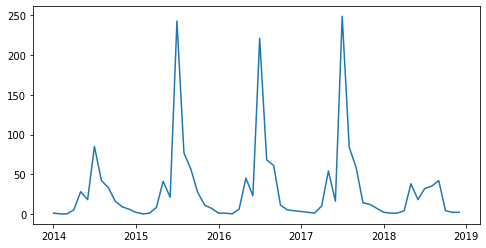

In [147]:
plt.figure(figsize=(8,4))
plt.plot(ts1, label='dengue cases')

## Dickey-Fuller Test
Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.
A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time.
ost of the TS models work on the assumption that the TS is stationary. Intuitively, we can sat that if a TS has a particular behaviour over time, there is a very high probability that it will follow the same in the future.
Stationarity is defined using very strict criterion. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:
   
   1.constant mean
    
   2.constant variance
    
   3.an autocovariance that does not depend on time.

In [148]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

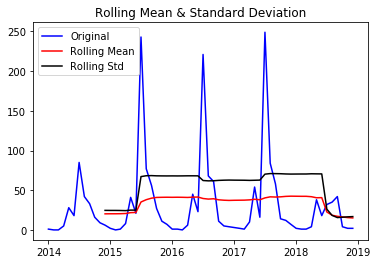

Results of Dickey-Fuller Test:
Test Statistic                 -0.971800
p-value                         0.763410
#Lags Used                     11.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Value (5%)            -2.923954
Critical Value (10%)           -2.600039
dtype: float64


In [149]:
test_stationarity(ts1)

If the p-value is less than 0.05, we reject the null hypothesis
Here the null hypothesis is that the TS is non-stationary.

and 

the test statistic is way more than the critical values

so - the time series is non-stationary and we need to make it stationary

what is making a TS non-stationary. There are 2 major reasons behind non-stationaruty of a TS:
1. Trend – varying mean over time. 
2. Seasonality – variations at specific time-frames.

The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.

## Eliminating Trend and Seasonality

two ways of removing trend and seasonality:

    1.Differencing – taking the differece with a particular time lag
    2.Decomposition – modeling both trend and seasonality and removing them from the model.
 
### Differencing

One of the most common methods of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the observation at a particular instant with that at the previous instant. This mostly works well in improving stationarity. First order differencing can be done in Pandas as:

In [94]:
#ts_log = np.cbrt(ts1) # cube root transformation.
#plt.plot(ts_log)

In [150]:
ts_log=ts1

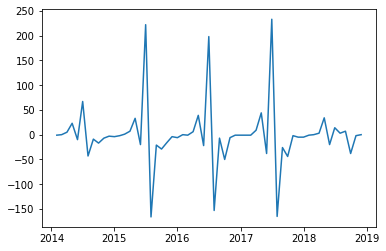

In [151]:
#ts_log_diff = ts_log - ts_log.shift()
ts_log_diff1=ts_log.diff().dropna()
plt.plot(ts_log_diff1)

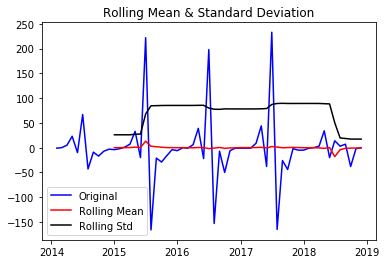

Results of Dickey-Fuller Test:
Test Statistic                -8.682089e+00
p-value                        4.259002e-14
#Lags Used                     1.000000e+01
Number of Observations Used    4.800000e+01
Critical Value (1%)           -3.574589e+00
Critical Value (5%)           -2.923954e+00
Critical Value (10%)          -2.600039e+00
dtype: float64


In [152]:
test_stationarity(ts_log_diff1)

In [211]:
#ts_log_diff = ts_log - ts_log.shift()
#ts_log_diff2=ts_log.diff().diff().dropna()


Here p value is less than 0.05 and Test Statistic is less tthan the Critical Value, so we reject the null hypothesis, the given series is now stationary

### Decomposition

For better results we can also perform decomposition. In this approach, both trend and seasonality are modeled separately and the remaining part of the series is returned. Here we can see that the trend, seasonality are separated out from data and we can model the residuals.

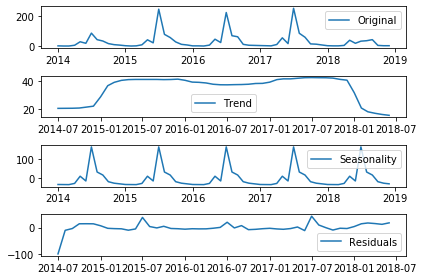

In [155]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

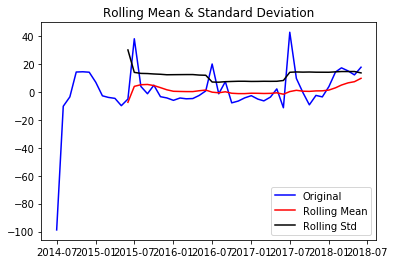

Results of Dickey-Fuller Test:
Test Statistic                -9.304874e+00
p-value                        1.087571e-15
#Lags Used                     0.000000e+00
Number of Observations Used    4.700000e+01
Critical Value (1%)           -3.577848e+00
Critical Value (5%)           -2.925338e+00
Critical Value (10%)          -2.600774e+00
dtype: float64


In [156]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

The Dickey-Fuller test statistic is significantly lower than the 1% critical value. So this TS is very close to stationary.

## Forecasting

Its relatively easier to add noise and seasonality back into predicted residuals in this case. Having performed the trend and seasonality estimation techniques, there can be two situations

    1.A strictly stationary series with no dependence among the values. This is the easy case wherein we can model the   residuals as white noise. But this is very rare.
    2.A series with significant dependence among values. In this case we need to use some statistical models like ARIMA to forecast the data.
    
Here our time series has significant dependence among the values.

ARIMA stands for Auto-Regressive Integrated Moving Averages. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

    1.Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
    2.Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
    3.Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.
    
We use two plots to determine p and q

    1.Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
    2.Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.
    
The ACF and PACF plots for the TS after differencing.

In [157]:
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot
%matplotlib inline

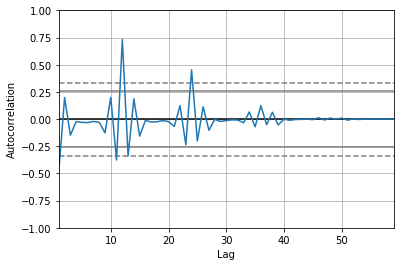

In [158]:
autocorrelation_plot(ts_log_diff1)
plt.show()

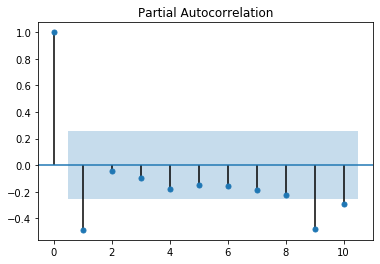

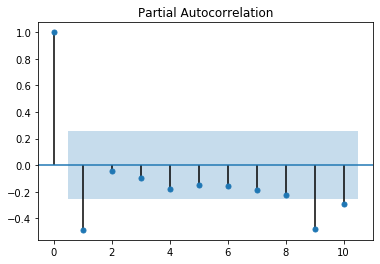

In [213]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(ts_log_diff1, lags=10)

In this plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:

p – The lag value where the PACF chart crosses the upper confidence interval for the first time. 

q – The lag value where the ACF chart crosses the upper confidence interval for the first time.

## ARIMA - Model

In [217]:
from statsmodels.tsa.arima_model import ARIMA   #p,d,q

Text(0.5, 1.0, 'RSS: 153770.9457')

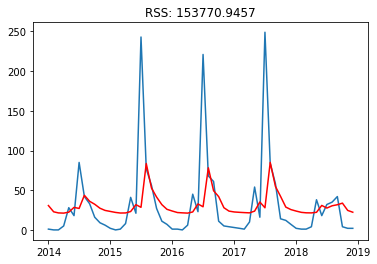

In [220]:
model = ARIMA(ts_log, order=(1, 0, 1))  
results_ARIMA = model.fit()  
plt.plot(ts_log)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log)**2))

In [221]:
print(results_ARIMA.summary())

                              ARMA Model Results                              
Dep. Variable:                 dengue   No. Observations:                   60
Model:                     ARMA(1, 1)   Log Likelihood                -320.629
Method:                       css-mle   S.D. of innovations             50.614
Date:                Wed, 03 Jun 2020   AIC                            649.258
Time:                        01:32:08   BIC                            657.636
Sample:                    01-01-2014   HQIC                           652.535
                         - 12-01-2018                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           30.6856      9.428      3.255      0.001      12.208      49.163
ar.L1.dengue     0.4471      0.242      1.846      0.065      -0.027       0.922
ma.L1.dengue    -0.1958      0.243     -0.80

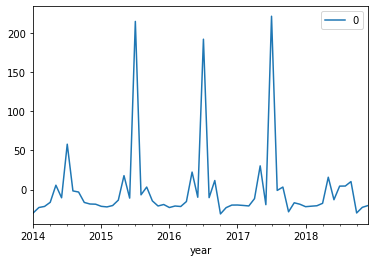

In [222]:
#results_ARIMA.resid
from pandas import DataFrame
residuals=DataFrame(results_ARIMA.resid)

residuals.plot()

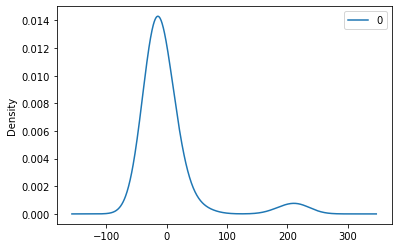

In [223]:
residuals.plot(kind='kde')

In [224]:
residuals.describe()

,0
count,60.000000
mean,0.202154
std,51.051402
min,-30.962122
25%,-20.855654
50%,-16.538445
75%,0.067388
max,221.126486


Text(0.5, 1.0, 'RSS: nan')

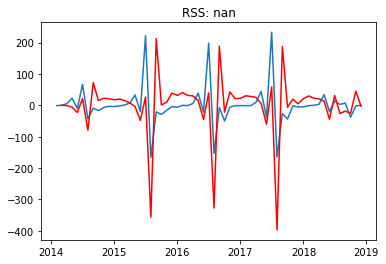

In [225]:
model = ARIMA(ts_log_diff1, order=(4,1,2))  
results_ARIMA = model.fit()  
plt.plot(ts_log_diff1)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff1)**2))

In [226]:
print(results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.dengue   No. Observations:                   58
Model:                 ARIMA(4, 1, 2)   Log Likelihood                -313.499
Method:                       css-mle   S.D. of innovations             47.838
Date:                Wed, 03 Jun 2020   AIC                            642.999
Time:                        01:32:13   BIC                            659.482
Sample:                    03-01-2014   HQIC                           649.419
                         - 12-01-2018                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0788      0.054     -1.454      0.146      -0.185       0.027
ar.L1.D.dengue     0.2019      0.130      1.550      0.121      -0.053       0.457
ar.L2.D.dengue     0.2497      0.127

In [227]:
residuals=DataFrame(results_ARIMA.resid)

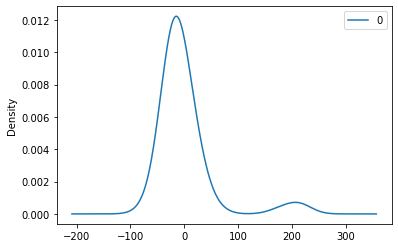

In [228]:
residuals.plot(kind='kde')

In [229]:
residuals.describe()

,0
count,58.000000
mean,-0.301449
std,52.527990
min,-67.404075
25%,-23.328515
50%,-13.911984
75%,2.884212
max,215.638588


In [232]:
start_index = len(ts_log_diff1)
end_index = start_index + 10
forecast = results_ARIMA.predict(start=start_index, end=end_index, typ='levels')
print(forecast)

2019-01-01   -3.799758
2019-02-01    7.841261
2019-03-01   -6.620794
2019-04-01    0.758943
2019-05-01   -2.062148
2019-06-01   -0.767011
2019-07-01    0.406047
2019-08-01   -0.004981
2019-09-01    0.542664
2019-10-01    0.121224
2019-11-01    0.012714
Freq: MS, dtype: float64
